# Sprint 1: Data analysis and supervised learning

Tijdens deze eerste sprint wordt enkel gefocust op het classificeren op basis van de verschillende product en issue categorieën. In de volgende sprints zullen ook de classificatie van sub-producten en sub-issues aan bod komen.

## Exploratory Data Analysis

Inlezen van het CSV bestand naar een DataFrame.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re, string

rows_to_read = None # Gewenst aantal rijen inlezen (None = allemaal)

complaints = pd.read_csv('data/complaints.csv', delimiter=',', nrows=rows_to_read)

rows, cols = complaints.shape

print(f'Er zijn {rows} rijen en {cols} kolommen')

Er zijn 485701 rijen en 18 kolommen


Om een overzicht te krijgen van de gebruikte kolommen en de hoeveelheid data, maken we hier gebruik van de info() methode.

In [16]:
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485701 entries, 0 to 485700
Data columns (total 18 columns):
Date received                   485701 non-null object
Product                         485701 non-null object
Sub-product                     485701 non-null object
Issue                           485701 non-null object
Sub-issue                       485701 non-null object
Consumer complaint narrative    485701 non-null object
Company public response         485701 non-null object
Company                         485701 non-null object
State                           485701 non-null object
ZIP code                        485701 non-null object
Tags                            485701 non-null object
Consumer consent provided?      485701 non-null object
Submitted via                   485701 non-null object
Date sent to company            485701 non-null object
Company response to consumer    485701 non-null object
Timely response?                485701 non-null object
Consumer 

De Dataframe aanpassen naar de belangrijkste kolommen.
- Product
- Sub-product
- Issue
- Sub-issue
- Consumer complaint narrative

In [17]:
complaints_df = complaints[['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative']].copy()

# Kolommen een simpelere naam geven
complaints_df.columns = ['Product', 'Sub_Product', 'Issue', 'Sub_Issue', 'Narrative'] 
complaints_df.head()

,Product,Sub_Product,Issue,Sub_Issue,Narrative
0,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...
1,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,please review the current fraud account and al...
2,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,Called multiple times over the years for a deb...
3,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I sent in a letter to the company to have them...
4,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Received unsolicited financial product or insu...,On XX/XX/19 I applied for a Debt Relief Produc...


### Aantal klachten per categorie van producten

In [20]:
complaints_df.Product.unique()

array(['Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Payday loan, title loan, or personal loan',
       'Mortgage', 'Credit card or prepaid card',
       'Checking or savings account', 'Student loan',
       'Vehicle loan or lease',
       'Money transfer, virtual currency, or money service',
       'Credit card', 'Bank account or service', 'Payday loan',
       'Credit reporting', 'Consumer Loan', 'Money transfers',
       'Prepaid card', 'Other financial service', 'Virtual currency'],
      dtype=object)


Er zijn meer dan 10 verschillende categorieën voor de producten. Sommige zijn echter heel erg gerelateerd aan elkaar. Daarom kan het nuttig zijn om sommige categorieën samen te nemen om de accuraatheid van het te bekomen model te verbeteren.
- 'Credit reporting, repair, or other'
    - 'Credit reporting, credit repair services, or other personal consumer reports'
    - 'Credit reporting'
- 'Credit card or prepaid card'
    - 'Credit card'
    - 'Prepaid card'
- 'Payday loan, title loan, or personal loan
    - 'Payday loan'
- 'Money transfer, virtual currency, or money service'
    - 'Money transfer' 
    - 'Virtual currency'

In [21]:
complaints_df.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [24]:
complaints_df.Product.unique()

array(['Credit reporting, repair, or other', 'Debt collection',
       'Payday loan, title loan, or personal loan', 'Mortgage',
       'Credit card or prepaid card', 'Checking or savings account',
       'Student loan', 'Vehicle loan or lease',
       'Money transfer, virtual currency, or money service',
       'Bank account or service', 'Consumer Loan', 'Money transfers',
       'Other financial service'], dtype=object)

Er blijven nu slechts 13 product categorieën over.

Om het mogelijk te maken om een model te ontwikkelen gaan we elke categorie die in tekstvorm in de dataset staat, gaan voorstellen als een getal. Hiervoor voegen we een nieuwe kolom toe met als naam 'Category_Id'.

In [25]:
complaints_df['Category_Id'] = complaints_df['Product'].factorize()[0]

# Dictionary aanmaken die de 'Category_Id - Product' combinaties bevat
categories = dict(complaints_df[['Category_Id', 'Product']].drop_duplicates().values)
categories

{0: 'Credit reporting, repair, or other',
 1: 'Debt collection',
 2: 'Payday loan, title loan, or personal loan',
 3: 'Mortgage',
 4: 'Credit card or prepaid card',
 5: 'Checking or savings account',
 6: 'Student loan',
 7: 'Vehicle loan or lease',
 8: 'Money transfer, virtual currency, or money service',
 9: 'Bank account or service',
 10: 'Consumer Loan',
 11: 'Money transfers',
 12: 'Other financial service'}

In [26]:
# Nieuwe DataFrame met de extra kolom weergeven
complaints_df.head()

,Product,Sub_Product,Issue,Sub_Issue,Narrative,Category_Id
0,"Credit reporting, repair, or other",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...,0
1,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,please review the current fraud account and al...,1
2,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,Called multiple times over the years for a deb...,1
3,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I sent in a letter to the company to have them...,1
4,"Credit reporting, repair, or other",Credit reporting,Improper use of your report,Received unsolicited financial product or insu...,On XX/XX/19 I applied for a Debt Relief Produc...,0


Vervolgens gaan we het aantal complaints per product tellen.

In [27]:
# Aantal products
product_counts = pd.DataFrame({'Count': complaints_df.groupby(['Product']).size()})
product_counts

,Count
Product,
Bank account or service,14885
Checking or savings account,18784
Consumer Loan,9473
Credit card or prepaid card,51770
"Credit reporting, repair, or other",173330
Debt collection,105765
"Money transfer, virtual currency, or money service",7751
Money transfers,1497
Mortgage,61094


<Figure size 720x360 with 0 Axes>

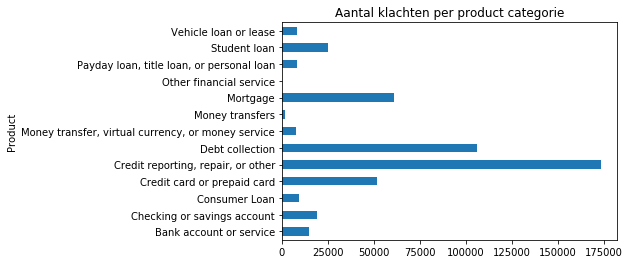

In [28]:
fig = plt.figure(figsize=(10, 5))
product_counts.plot.barh(title="Aantal klachten per product categorie", legend=None)

De verdeling van de data over de verschillende categorieën is niet gebalanceerd. Dit kan voor problemen zorgen bij het classificeren aangezien de kleine categorieën als uitschieters gezien kunnen worden. We zouden deze categorieën kunnen oversampelen zodat de dataset gebalanceerd wordt, maar aangezien de categorieën die het meest voorkomen ook het meest waarschijnlijk voorkomen tijdens het classificeren, zullen we dit niet doen.

Om deze categorieën van producten en sub-producten beter te begrijpen, gaan we het verband tussen beiden gaan onderzoeken.

In [29]:
sub_product_counts = pd.DataFrame({'Count': complaints_df.groupby(['Product', 'Sub_Product']).size()})
sub_product_counts.head(10)

Count
Product                     Sub_Product                              
Bank account or service     (CD) Certificate of deposit           274
                            Cashing a check without an account    134
                            Checking account                    10113
                            Other bank product/service           3477
                            Savings account                       887
Checking or savings account CD (Certificate of Deposit)           338
                            Checking account                    15632
                            Other banking product or service     1483
                            Personal line of credit                14
                            Savings account                      1317

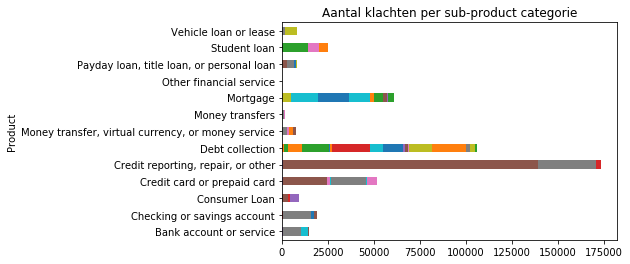

In [30]:
sub_product_counts.unstack().plot(kind='barh', stacked=True, legend=None, title="Aantal klachten per sub-product categorie")

### Aantal klachten per categorie van issues

Hieronder worden het aantal complaints per issue geteld en worden de distributies van de sub-issues getoond.

In [31]:
issue_counts = complaints_df.groupby('Issue')['Issue'].count()
issue_counts.sort_values(ascending=False)

Issue
Incorrect information on your report                                                77776
Problem with a credit reporting company's investigation into an existing problem    38424
Attempts to collect debt not owed                                                   28629
Incorrect information on credit report                                              21217
Improper use of your report                                                         20239
                                                                                    ...  
Property was sold                                                                       3
Property was damaged or destroyed property                                              2
Problem with an overdraft                                                               2
Lender damaged or destroyed vehicle                                                     2
Lender damaged or destroyed property                                                    1
Name

In [32]:
subissue_counts = pd.DataFrame({'Count': complaints_df.groupby(['Issue', 'Sub_Issue'])['Sub_Issue'].count()})
subissue_counts.sort_values(by=['Issue','Count'],ascending=[True,False])

Count
Issue                                              Sub_Issue                                                
APR or interest rate                               None                                                  785
Account opening, closing, or management            None                                                 6347
Account terms and changes                          None                                                   17
Adding money                                       None                                                   92
Advertising                                        Confusing or misleading advertising about the card     59
...                                                                                                      ...
Was approved for a loan, but didn't receive the... None                                                   65
Written notification about debt                    Didn't receive enough information to verify debt     7611
                                                   Didn't receive notice of right to dispute            4323
                                                   Notification didn't disclose it was an attempt ...    431
Wrong amount charged or received                   None                                                  248

[354 rows x 1 columns]

Voor een duidelijker overzicht worden de 20 meest voorkomende issues geplot in een histogram.

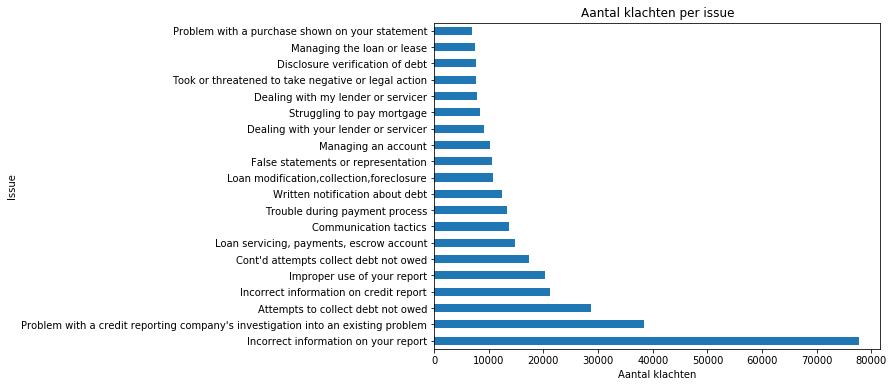

In [33]:
fig = plt.figure(figsize=(8,6))
issue_counts.sort_values(ascending=False).head(20).plot.barh(title="Aantal klachten per issue")
plt.xlabel('Aantal klachten', fontsize = 10);

Zoals je ziet zijn er veel verschillende issues (161) en is de data ongebalanceerd. Daarom zullen we enkel de 20 meest voorkomende issues gebruiken om het model te trainen. Dit is namelijk 71% van alle data. Hier worden ze nog eens getoond.

In [34]:
som = 0
for aantal in issue_counts.sort_values(ascending=False).head(20):
    som += aantal
print('Percentage: ' + str(round(som/len(complaints_df.index)*100)) + '%')
issue_counts.sort_values(ascending=False).head(20)

Percentage: 71%


Issue
Incorrect information on your report                                                77776
Problem with a credit reporting company's investigation into an existing problem    38424
Attempts to collect debt not owed                                                   28629
Incorrect information on credit report                                              21217
Improper use of your report                                                         20239
Cont'd attempts collect debt not owed                                               17434
Loan servicing, payments, escrow account                                            14722
Communication tactics                                                               13711
Trouble during payment process                                                      13280
Written notification about debt                                                     12365
Loan modification,collection,foreclosure                                            10789
Fals

Wat opvalt is dat sommige categorieën een andere naam krijgen maar dat de data eigenlijk onder dezelfde categorie zou mogen geplaatst worden. Dit is bijvoorbeeld het geval bij 'Attempts to collect debt not owed' en 'Cont'd attempts collect debt not owed'. Daarom zullen we deze kolommen samen nemen onder dezelfde noemer.

In [35]:
complaints_df.replace({'Issue': 
            {'Cont\'d attempts collect debt not owed':'Attempts to collect debt not owed',
            'Dealing with my lender or servicer':'Dealing with your lender or servicer'}}, 
            inplace= True)
issue_counts = complaints_df.groupby('Issue')['Issue'].count()
#door 2 issues gelijk te stellen aan andere issues houden we er nog 18 verschillende over
issue_counts.sort_values(ascending=False).head(18)

Issue
Incorrect information on your report                                                77776
Attempts to collect debt not owed                                                   46063
Problem with a credit reporting company's investigation into an existing problem    38424
Incorrect information on credit report                                              21217
Improper use of your report                                                         20239
Dealing with your lender or servicer                                                17063
Loan servicing, payments, escrow account                                            14722
Communication tactics                                                               13711
Trouble during payment process                                                      13280
Written notification about debt                                                     12365
Loan modification,collection,foreclosure                                            10789
Fals

Nu filteren we de complaints zodat enkel degene met de meest voorkomende issues overblijven.

In [37]:
issue_list = ['Incorrect information on your report',
       'Attempts to collect debt not owed',
       'Problem with a credit reporting company\'s investigation into an existing problem',
       'Incorrect information on credit report',
       'Improper use of your report',
       'Dealing with your lender or servicer',
       'Loan servicing, payments, escrow account',
       'Communication tactics',
       'Trouble during payment process',
       'Written notification about debt',
       'Loan modification,collection,foreclosure',
       'False statements or representation',
       'Managing an account',
       'Struggling to pay mortgage',
       'Took or threatened to take negative or legal action',
       'Disclosure verification of debt',
       'Managing the loan or lease',
       'Problem with a purchase shown on your statement']
complaints_df_ = complaints_df[complaints_df['Issue'].isin(issue_list)]
complaints_df.head()

,Product,Sub_Product,Issue,Sub_Issue,Narrative,Category_Id
0,"Credit reporting, repair, or other",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...,0
1,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,please review the current fraud account and al...,1
2,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,Called multiple times over the years for a deb...,1
3,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I sent in a letter to the company to have them...,1
4,"Credit reporting, repair, or other",Credit reporting,Improper use of your report,Received unsolicited financial product or insu...,On XX/XX/19 I applied for a Debt Relief Produc...,0


## Data pre-processing

Via volgende methode kunnen we alle speciale tekens en specifieke tekens ten gevolge van anonimisering (XXX ...) uit de dataset weghalen.

In [38]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder
stop_words = ENGLISH_STOP_WORDS

def clean_tokenized(string):
    # Omzetten naar lowercase 
    string =string.lower()
    # Alles wat niet gelijk is aan een lowercase of whitespace eruit filteren
    string = re.sub(r'[^\w\s]','',string)
    # Alle getallen eruit filteren
    string = re.sub(r'[0-9]|,','',string)
    # Returns en newlines eruithalen
    string = string.replace('\r',' ')
    string = string.replace('\n',' ')
    # Kaart nummers staan in de tekst als volgt XXX XXX ..., deze eruit filteren
    string = re.sub(r'[X|x]{2,}',' ',string)
    # de string splitten om de stop woorden er afzonderlijk uit te halen
    words = string.split(' ')
    no_stop = [w for w in words if w not in stop_words]
    return no_stop

def clean_string(string):
    inp=clean_tokenized(string)
    return " ".join(inp)

In [39]:
complaints_df['Narrative_clean'] = complaints_df['Narrative'].apply(clean_string)
complaints_df['Narrative_clean_tokenized'] = complaints_df['Narrative'].apply(clean_tokenized)

### Meest voorkomende woorden in elk product categorie

Om tekst als invoer te gebruiken voor algoritmes, moeten we deze gaan converteren naar bruikbare data. We berekenen hiervoor de Term Frequency en Inverse Document Frequency (TF-IDF).
- Term Frequency: beschrijft relatief hoeveel keer een gegeven woord in een document voorkomt ten opzichte van het totaal aantal woorden
- Inverse Document Frequency: beschrijft het aantal keer een bepaalde term voorkomt over meerdere documenten
    - Hoge IDF: term komt slechts voor in een paar documenten
    - Lage IDF: term komt in veel documenten voor

TfidfVectorizer class wordt geïnitialiseerd met de volgende paramters:
- `min_df`: verwijder de termen die in minder dan deze waarde aantal documenten voorkomt
- `sublinear_tf`: term frequentie op een logaritmische schaal plaatsen
- `stop_words`: verwijder specifieke (vaak voorkomende) stop woorden uit het Engels
- `ngram_range`: (1, 2) geeft aan dat zowel termen uit 1 woord (unigram), als termen die uit 2 woorden (bigram) bestaat kunnen gebruikt worden

Om dit te realiseren gaan we eerst elke klacht narrative omvormen naar een array van termen (= features).

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVector = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')

features = tfidfVector.fit_transform(complaints_df.head(10000)['Narrative_clean']).toarray()
labels = complaints_df.head(10000).Category_Id

print("De %d verschillende klachten worden voorgeteld door %d features" %(features.shape))

De 10000 verschillende klachten worden voorgeteld door 24471 features


Vervolgens gaan we voor elke categorie de meest voorkomende termen gaan selecteren aan de hand van de Chi-square verdeling.
- Unigrams: termen die slechts uit 1 woord bestaan
- Bigrams: termen die uit 2 woorden bestaan

De parameters voor de Chi-square verdeling zijn als volgt:
- X: features: (Category_Id, [features]) tuples
- y: labels (Category_Id)
- returns: (chi2_values, pvalues) tuples

Hiermee kunnen de Chi-square waarden berekend worden voor elke feature per categorie. Vervolgens kunnen we de features sorteren op de hoogste waarde om zo de features met hoogste frequentie te bepalen. Hier schrijven we telkens voor elke categorie de 3 meest voorkomende features uit.

In [42]:
from sklearn.feature_selection import chi2

N = 3
for Category_Id, Product in sorted(categories.items()):
    features_chi2 = chi2(features, labels == Category_Id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidfVector.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    print("\n%s:" %(Product))
    print("\tUnigrams: %s" %(', '.join(unigrams[-N:])))
    print("\tBigrams: %s" %(', '.join(bigrams[-N:])))


Credit reporting, repair, or other:
	Unigrams: equifax, reporting, report
	Bigrams: identity theft, credit file, credit report

Debt collection:
	Unigrams: collect, collection, debt
	Bigrams: debt collection, collection agency, collect debt

Payday loan, title loan, or personal loan:
	Unigrams: tower, borrowed, loan
	Bigrams: installment loan, pay loan, title loan

Mortgage:
	Unigrams: foreclosure, escrow, mortgage
	Bigrams: loan modification, mortgage company, escrow account

Credit card or prepaid card:
	Unigrams: citi, express, card
	Bigrams: new card, american express, credit card

Checking or savings account:
	Unigrams: savings, branch, deposit
	Bigrams: direct deposit, savings account, checking account

Student loan:
	Unigrams: loans, student, navient
	Bigrams: student loans, student loan, loan forgiveness

Vehicle loan or lease:
	Unigrams: ally, vehicle, car
	Bigrams: ally financial, santander consumer, consumer usa

Money transfer, virtual currency, or money service:
	Unigrams

### Een alternatieve benadering voor feature selection wordt hieronder uitgewerkt

Eerst stellen we een dataframe op voor elke category. Elke dataframe wordt bijgehouden in de df_categorieen lijst.

In [47]:
df_categorieen = []
for cat in complaints_df.Product.unique():
    df_cat = complaints_df.head(10000).loc[complaints_df['Product'] == cat]
    df_categorieen.append(df_cat)

df_categorieen[0]
complaints_df.head(10000).Product.unique()

array(['Credit reporting, repair, or other', 'Debt collection',
       'Payday loan, title loan, or personal loan', 'Mortgage',
       'Credit card or prepaid card', 'Checking or savings account',
       'Student loan', 'Vehicle loan or lease',
       'Money transfer, virtual currency, or money service',
       'Bank account or service'], dtype=object)

Via volgende functie kunnen we de 15 meest gebruikte woorden berekenen van een categorie.

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def word_count(df,amount):
    try:
        count_vect = CountVectorizer(analyzer='word',stop_words="english", ngram_range=(amount, amount),min_df=1, max_df=1.0)
        df['Narrative']
        X_train_counts = count_vect.fit_transform(df['Narrative_clean'])

        feature_names=count_vect.get_feature_names()
        feature_names

        word_count=[]
        for i in range(len(feature_names)):
            word_count.append(0)

        for complaint in X_train_counts.toarray():
            counter = 0
            for word in complaint:
                word_count[counter] += word
                counter += 1

        df_wc =  pd.DataFrame({'name':feature_names, 'count':word_count})
        df_wc = df_wc.sort_values(by=["count"],ascending=False).head(n=15)
        return df_wc.reset_index(drop=True)
    except ValueError:
        print("Empty vocabulary")

Nu overlopen we de dataframes van alle categorieën.
Telkens krijgen we de meest gebruikte woorden van de categorie terug in een dataframe door middel van bovenstaande functie.
Vervolgens concateneren we al deze dataframes om een overzicht van de meest gebruikte woorden te bekomen.

In [49]:
top_words_percat = []
for df_cat in df_categorieen:
    top_words_percat.append(word_count(df_cat,1))

Empty vocabulary
Empty vocabulary
Empty vocabulary


In [50]:
col_names_wordcount = []
for cat in complaints_df.head(10000).Product.unique():
    col_names_wordcount.append(cat)
    col_names_wordcount.append('count')
df_wc_single = pd.concat(top_words_percat, axis=1)
df_wc_single.columns = col_names_wordcount
df_wc_single

,"Credit reporting, repair, or other",count,Debt collection,count,"Payday loan, title loan, or personal loan",count,Mortgage,count,Credit card or prepaid card,count,Checking or savings account,count,Student loan,count,Vehicle loan or lease,count,"Money transfer, virtual currency, or money service",count,Bank account or service,count
0,credit,10721,debt,3382,loan,354,mortgage,1812,card,2389,account,2312,loan,671,car,450,account,574,scottrade,7
1,report,6208,credit,2853,account,197,loan,1747,credit,2183,bank,1289,payments,464,loan,337,money,452,customer,5
2,information,5766,account,2198,payment,188,payment,1424,account,1783,money,595,loans,413,payment,335,bank,376,year,4
3,consumer,5495,company,1574,credit,153,home,794,bank,790,told,509,payment,392,credit,266,paypal,323,information,4
4,reporting,5307,collection,1385,pay,152,payments,751,payment,777,check,461,student,298,payments,212,told,191,bonus,4
5,account,5200,report,1280,company,145,account,731,told,764,funds,416,navient,278,told,175,sent,183,bank,3
6,accounts,2889,information,1168,told,141,received,704,called,706,called,381,pay,221,company,166,transaction,182,rep,3
7,agency,2171,received,1060,paid,136,company,625,did,674,did,380,account,212,account,160,said,166,promotion,3
8,identity,2111,letter,941,payments,122,told,624,received,604,checking,380,told,209,financial,151,called,145,nt,3
9,section,1906,sent,920,called,99,time,587,time,603,received,358,information,194,vehicle,148,number,145,told,3


Op een analoge manier bepalen we de meeste gebruikte bigrams bepalen per categorie.

In [51]:
top_words_percat_double = []
for df_cat in df_categorieen:
    top_words_percat_double.append(word_count(df_cat,2))
df_wc_double = pd.concat(top_words_percat_double, axis=1)
df_wc_double.columns = col_names_wordcount
df_wc_double

Empty vocabulary
Empty vocabulary
Empty vocabulary


,"Credit reporting, repair, or other",count,Debt collection,count,"Payday loan, title loan, or personal loan",count,Mortgage,count,Credit card or prepaid card,count,Checking or savings account,count,Student loan,count,Vehicle loan or lease,count,"Money transfer, virtual currency, or money service",count,Bank account or service,count
0,credit report,3371,credit report,780,line credit,28,wells fargo,244,credit card,929,checking account,274,student loan,151,gm financial,48,bank account,57,year true,2
1,identity theft,1683,collection agency,318,paid paid,27,mortgage company,203,customer service,263,wells fargo,158,student loans,116,credit report,40,credit card,47,bank west,2
2,reporting agency,1560,debt collection,261,customer service,25,loan modification,169,american express,224,customer service,132,loan forgiveness,71,auto loan,36,wire department,41,social security,2
3,consumer reporting,1497,identity theft,243,checking account,23,customer service,134,credit report,153,bank america,119,sallie mae,61,customer service,30,cash app,40,customer care,2
4,credit reporting,930,credit reporting,229,pay loan,21,escrow account,133,credit score,97,savings account,102,qualifying payments,60,financial services,28,customer service,37,hold rep,2
5,credit bureaus,769,credit bureaus,223,credit score,19,mortgage payment,123,credit cards,93,close account,97,repayment plan,58,credit bureaus,28,bank america,36,house hold,2
6,credit score,595,original creditor,203,credit report,17,loan servicing,96,bank america,88,bank account,95,monthly payment,40,wells fargo,25,send money,33,rep received,2
7,credit file,502,credit card,195,bank account,16,mortgage loan,96,synchrony bank,85,debit card,95,phone calls,37,car loan,24,paypal account,31,received bonus,2
8,credit card,424,credit reports,191,make payment,15,mr cooper,94,late payment,84,direct deposit,78,customer service,34,insurance company,23,phone number,30,told qualified,2
9,credit reports,415,debt collector,177,paid loan,12,monthly payment,92,late fee,83,account closed,77,department education,33,credit score,21,wells fargo,29,promotion applied,2


Hier worden de frequenties van de unigrams op een alternatieve manier berekend.

In [53]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder

def word_freq(tokens, n):
    merged = [item for sublist in tokens for item in sublist]
    counts = Counter(merged)
    top = counts.most_common(n)
    word = [w[0] for w in top]
    num = [w[1] for w in top]
    return pd.DataFrame([word, num]).T

#lijsten van dataframes
dataframes = []
test_dataframes = []

#elke issue overlopen
for i in range(len(issue_list)):
    #nieuwe dataframe voor specifieke issue
    new = complaints_df.loc[complaints_df['Issue'] == issue_list[i]]
    #eerste 5 rijen opzij houden om later te testen
    test_dataframes.append(new.iloc[:5])
    #andere rijen toevo
    dataframes.append(new.iloc[5:])

#dataframes terug aan elkaar hangen
df = pd.concat(dataframes)
test_df = pd.concat(test_dataframes)

#nummer toewijzen aan issues
LE = LabelEncoder()
complaints_df['Issue_Id'] = LE.fit_transform(complaints_df['Issue'])

#Top 20 woorden per issue

n = 20
frequencies = []

#elke issue overlopen
for i in range(len(issue_list)):
    tokens = dataframes[i]['Narrative_clean_tokenized'].tolist()
    #word_freq functie toepassen
    frequencies.append(word_freq(tokens, n))

df_freq = pd.concat(frequencies, axis=1)
#kolomnamen duidelijker maken
col_names = []
for issue in issue_list:
    col_names.append(issue)
    col_names.append('freq')
df_freq.columns = col_names
df_freq

,Incorrect information on your report,freq,Attempts to collect debt not owed,freq,Problem with a credit reporting company's investigation into an existing problem,freq,Incorrect information on credit report,freq,Improper use of your report,freq,...,Struggling to pay mortgage,freq,Took or threatened to take negative or legal action,freq,Disclosure verification of debt,freq,Managing the loan or lease,freq,Problem with a purchase shown on your statement,freq
0,,2656393,,1122426,,1217151,,503614,,813559,...,,441476,,286028,,136038,,214463,,340324
1,credit,174313,debt,75641,credit,98985,credit,46167,credit,50232,...,loan,21382,debt,15226,debt,16294,payment,14915,card,18277
2,account,102402,credit,66667,account,58508,report,27597,inquiry,25615,...,mortgage,19244,credit,10477,credit,11202,loan,10382,credit,15532
3,report,99147,account,55392,report,53185,account,23671,report,21210,...,modification,14841,account,7416,account,7494,account,8601,account,10794
4,information,84249,collection,34151,information,38538,information,17597,inquiries,15202,...,home,12351,company,6177,collection,6694,credit,8552,charges,8727
5,reporting,70460,report,33142,reporting,36818,reporting,12823,information,14801,...,payment,10378,received,5019,report,5026,car,7865,dispute,8641
6,consumer,53690,company,30982,accounts,23699,equifax,10554,did,9700,...,foreclosure,9133,collection,4908,received,4848,payments,7720,charge,8148
7,accounts,43146,information,23295,dispute,19370,accounts,8374,equifax,9045,...,payments,8923,told,4881,information,4617,told,6024,did,8080
8,payment,31187,received,21003,late,18908,removed,8005,hard,7934,...,told,8487,pay,4705,letter,4300,late,5714,bank,6844
9,company,27171,letter,19988,payment,18750,experian,7154,company,7624,...,time,8309,called,4506,company,4282,vehicle,5062,received,6604


## Classification Experiments: Multi-Class Text Classification

Multi-Classification modellen die we zullen evalueren:
- Random Forest
- Linear Support Vector Machine
- Multinomial Naive Bayes
- Logistic Regression
- K-nearest neighbors

### Product bepalen via classificatie

We maken een schatting van de accuraatheid van de verschillende classificatie algoritmen aan de hand van cross-validatie:

De cross-validatie functie wordt voor elk model met de volgende parameters uitgevoerd:
- `estimator`: het object die gebruikt wordt om de data te fitten (het model)
- `X`: de features die gefit moeten worden
- `y`: de target die we proberen te voorspellen (supervised learning)
- `scoring`: het score object die gebruikt moet worden
- `cv`: splitting strategie instellen (default = 5) om de data in sequenties van train en test stukken op te delen

In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier()
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\thoma\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The mi

KeyboardInterrupt: 

In [57]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
KNeighborsClassifier,0.4392,0.155342
LinearSVC,0.8194,0.005727
LogisticRegression,0.7918,0.006760
MultinomialNB,0.6570,0.008062
RandomForestClassifier,0.4840,0.001225


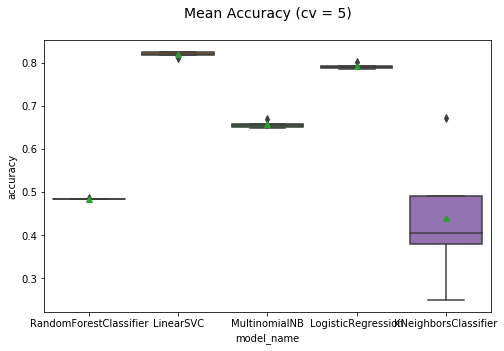

In [58]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', data=cv_df, showmeans=True)
plt.title("Mean Accuracy (cv = 5)\n", size=14);

We kunnen besluiten dat linear support vector classificatie de hoogste accuraatheid heeft en dus de voorkeur heeft.

Om een classificatie model te bekomen aan de hand van supervised learning, dienen we de originele dataset op te splitsen in train en test subsets. Op die manier kan het model getraind en getest worden op twee verschillende datasets. Zo kunnen we het algoritme gaan testen op een dataset die het algoritme nog niet gezien heeft.

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(3750, 12794)
(3750,)
(1250, 12794)
(1250,)


Nu kunnen we de uitkomsten van classificatie gaan voorspellen op de test subset met het getrainde model.

In [60]:
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Vervolgens gaan we deze voorspellingen gaan vergelijken met onze target en hieruit een rapport genereren die evalueert hoe goed ons classificatie model werkt.

In [62]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names= complaints_df['Product'].unique()))

                                                    precision    recall  f1-score   support

                Credit reporting, repair, or other       0.85      0.92      0.88       595
                                   Debt collection       0.79      0.78      0.78       268
         Payday loan, title loan, or personal loan       0.80      0.27      0.40        15
                                          Mortgage       0.91      0.89      0.90       114
                       Credit card or prepaid card       0.84      0.81      0.83       114
                       Checking or savings account       0.72      0.74      0.73        66
                                      Student loan       0.82      0.72      0.77        25
                             Vehicle loan or lease       0.69      0.34      0.46        32
Money transfer, virtual currency, or money service       0.75      0.43      0.55        21

                                          accuracy                           0

Om te gaan visualiseren hoe goed het model de categorieën voorspeld heeft, gaan we een confusion matrix genereren. Indien alle categorieën correct zouden voorspeld zijn, zouden enkel de cellen die op de diagonaal liggen een waarde mogen hebben.

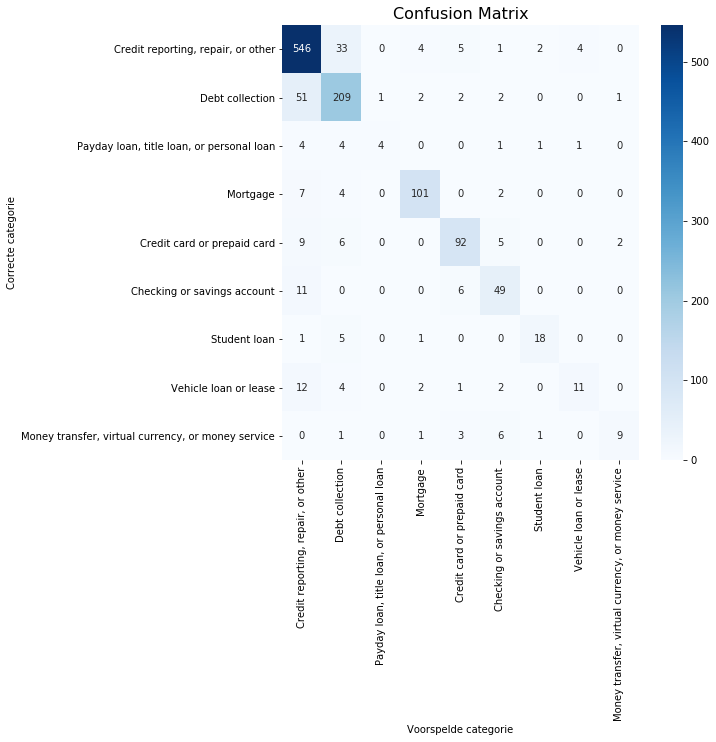

In [63]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d', xticklabels=categories.values(), yticklabels=categories.values())
plt.ylabel('Correcte categorie')
plt.xlabel('Voorspelde categorie')
plt.title("Confusion Matrix", size=16);

De diagonaal is duidelijk zichtbaar waardoor we kunnen besluiten dat ons classificatie model naar behoren werkt.

### Issue bepalen via classificatie

Uit de woordfrequenties van het vorige onderdeel kunnen we nu een aantal features berekenen. Term frequency en inverse document frequency (tf-idf) zijn goede features om te bepalen hoe belangrijk bepaalde woorden zijn voor een categorie. We berekenen ze aan de hand van de hulpfunctie TfidfVectorizer.

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens = df.head(10000)['Narrative_clean_tokenized'].astype('str')

#woorden die in meer dan 95% van de narratives voorkomen en woorden die in 5 of minder narratives voorkomen negeren 
#ook bigrams in rekening nemen
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                    min_df = 5, 
                                    max_df = .95)

#dit zijn alle features
X = tfidf_vectorizer.fit_transform(tokens)
#target
y = df.head(10000)['Issue_Id'].values

print(X.shape)
print(y.shape)

(10000, 18945)
(10000,)


We passen dimensionality reduction toe om de beste features uit te kiezen. Nu hebben we namelijk meer dan 18000 unieke unigrams en bigrams over 10000 rijen data, waarvan er waarschijnlijk veel niet veel nut hebben. Hiervoor gebruiken we Latent Semantic Analysis (LSA).

In [60]:
#imports
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=1000)

X = lsa.fit_transform(X)
X.shape

(10000, 1000)

Nu kunnen we enkele classifiers uittesten. De 5 classification modellen die eerder werden opgesomd worden hier getest.

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = [
    RandomForestClassifier(n_estimators=100, random_state=3),
    #LinearSVC(),
    #MultinomialNB(),
    #LogisticRegression(random_state=0),
    KNeighborsClassifier()
]

#training en test data opsplitsen
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

model_names, accuracies, precisions, recalls, f1s = [], [], [], [], []
comparison_df = pd.DataFrame()
for model in models:
    model_names.append(model.__class__.__name__)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))

comparison_df = pd.DataFrame([model_names, accuracies, precisions, recalls, f1s]).T
comparison_df.columns = ['model', 'accuracy', 'precision', 'recall', 'f1']
comparison_df.sort_values(by='f1', ascending=False)

,model,accuracy,precision,recall,f1
0,RandomForestClassifier,0.405,0.116906,0.113598,0.0994268
1,KNeighborsClassifier,0.297,0.108171,0.114501,0.0976969
